In [1]:
import numpy as np
import nyu
import scipy as sp
import scipy.io
import skimage
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('image', cmap='gray') # set default image colormap to gray

# try gaussian weighting of neighboring patches?

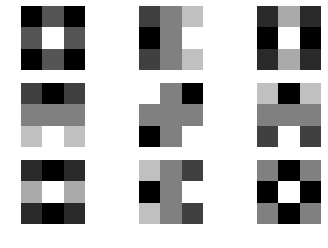

In [2]:
# 3x3 Laws filters from [Saxena et al. 2007]
L3 = np.array([1, 2, 1]) / 128 / .2
E3 = [-1, 0, 1]
S3 = [-1, 2, -1]

L3L3 = np.outer(L3, L3)
L3E3 = np.outer(L3, E3)
L3S3 = np.outer(L3, S3)
E3L3 = np.outer(E3, L3)
E3E3 = np.outer(E3, E3)
E3S3 = np.outer(E3, S3)
S3L3 = np.outer(S3, L3)
S3E3 = np.outer(S3, E3)
S3S3 = np.outer(S3, S3)

f, ax = plt.subplots(3, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0, 0].imshow(L3L3)
ax[0, 1].imshow(L3E3)
ax[0, 2].imshow(L3S3)
ax[1, 0].imshow(E3L3)
ax[1, 1].imshow(E3E3)
ax[1, 2].imshow(E3S3)
ax[2, 0].imshow(S3L3)
ax[2, 1].imshow(S3E3)
ax[2, 2].imshow(S3S3)

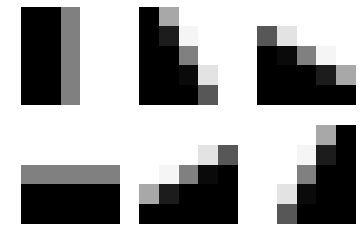

In [4]:
# Oriented edge filters from [Nevatia 1980]
NB0 = np.tile([-100, -100, 0, 100, 100], (5, 1)) / 2000
NB30 = np.array([
    [-100, 32, 100, 100, 100],
    [-100, -78, 92, 100, 100],
    [-100, -100, 0, 100, 100],
    [-100, -100, -92, 78, 100],
    [-100, -100, -100, -32, 100],
]) / 2000

NB60 = -NB30.T
NB90 = -NB0.T
NB120 = -np.flipud(NB60)
NB150 = NB120.T

f, ax = plt.subplots(2, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0, 0].imshow(NB0)
ax[0, 1].imshow(NB30)
ax[0, 2].imshow(NB60)
ax[1, 0].imshow(NB90)
ax[1, 1].imshow(NB120)
ax[1, 2].imshow(NB150)

In [7]:
def rescale(X):
    max_ = np.max(X)
    min_ = np.min(X)
    
    return (X - min_) / (max_ - min_)

def rescale_abs(X):
    return np.abs(rescale(X) - .5) # FIXME

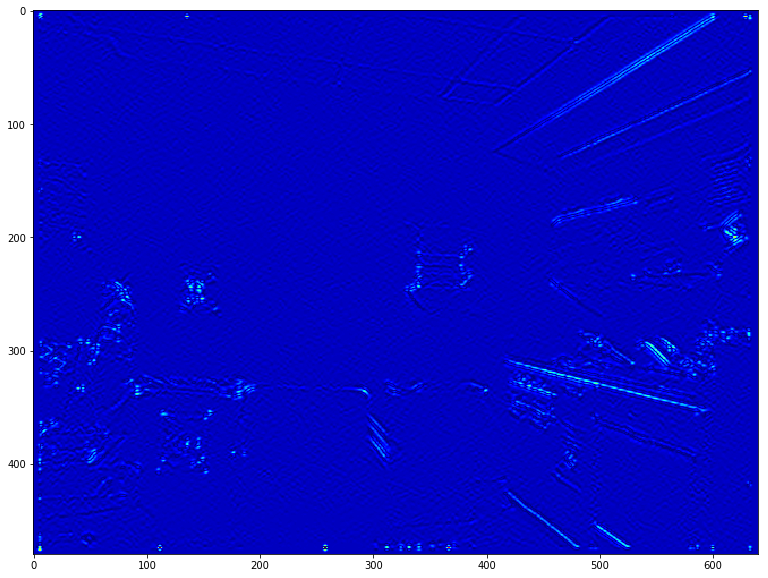

In [69]:
#asdf = sp.ndimage.filters.convolve(nyu['images'][train_indices[0]], L3L3)
#plt.imshow(asdf, cmap='gray')
example = np.transpose(nyu['images'][train_indices[0]], (2, 1, 0))
ycbcr = skimage.color.rgb2ycbcr(example)

blurred = sp.ndimage.filters.gaussian_filter(ycbcr[:, :, 0], 1)
filtered = sp.ndimage.filters.convolve(blurred, S3E3) / 255.0
plt.figure(figsize=(20,10))
plt.imshow(rescale_abs(filtered), cmap='jet')


In [2]:
# Adapted from [Ma, Geng, Bie 2017] pure CNN network

import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape
from tensorflow.keras.models import Sequential
import loss

N_EPOCHS = 40
BATCH_SIZE = 1

sequence = nyu.NyuSequence(batch_size=4, dims=(320, 240), depth_scale=.25)

H, W, _ = sequence.data_shape()
N = np.float32(W * H)
def scale_invariant_loss(y_true, y_pred):
    D = K.log(y_pred)
    D_star = K.log(y_true)
    d = D - D_star
    
    loss = (1 / N) * K.sum(K.pow(d, 2)) - (1 / K.pow(N, 2)) * K.pow(K.sum(d), 2)
    return loss

model = Sequential([
    Conv2D(96, 11, strides=4, activation='relu', padding='valid', input_shape=sequence.data_shape()),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(256, 5, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),
    Conv2D(384, 3, activation='relu', padding='same'),
    Conv2D(384, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4800, activation='linear'),
    Reshape((60, 80, 1))
])

for layer in model.layers:
    print(layer.output_shape)

model.compile(loss=loss.scale_invariant_gradient_loss(N), optimizer=tf.keras.optimizers.Adam(lr=.00001))
model.summary()
model.fit_generator(sequence, epochs=5, verbose=1)

Found nyu_depth_v2_labeled.mat
Found splits.mat
Instructions for updating:
Colocations handled automatically by placer.


TypeError: Value passed to parameter 'x' has DataType float64 not in list of allowed values: float32

In [3]:
model.layers[0].get_weights()

[array([[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         ...,
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],
 
 
        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, na

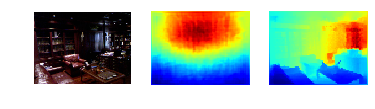

In [12]:
X, y = sequence[24]
img = X[0]
depth = y[0]
pred = model.predict(X)[0]

f, ax = plt.subplots(1, 3)
[x.set_axis_off() for x in ax.ravel()]
ax[0].imshow(img)
ax[1].imshow(pred[:, :, 0], cmap='jet')
ax[2].imshow(depth[:, :, 0], cmap='jet')

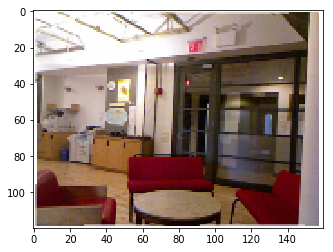

In [67]:
plt.imshow(skimage.transform.resize(example, (120, 160)))